Cross-shelf transport (total) of CNTDIFF experiments
==

This notebook explores the similarities and differences between the 2 tracer transports for case CNTDIFF as well as canyon and no canyon cases. It looks at the transport normal to a shelf break wall<sup>1</sup>. Total Tracer Transport (TracTrans) is understood here as tracer transport (concentration * transport) per cell area; similarly, Total Transport (Trans) is transport per cell area, which is only the speed. This gives the following units:

$[TracTrans] = [C]ms^{-1} $

$[Trans] = [v] = ms^{-1} $

TracTrans = AdvFlux + DiffFlux / cell area

<sup>1</sup> Plane that goes from shelf-break depth to surface and all along the shelf break.

The base case to compare the effect of isopycnal diffusivity is a run without GMREDI and different values of $K_{iso}$ but constant vertical diffusivity (CNTDIFF). The vertical diff for tracer 1 is $10^{-5}$ $m^2s^{-1}$ and $10^{-3}$ $m^2s^{-1}$ for tracer 2. An associated no-canyon case allows to isolate the effect of the canyon (CNTDIFF run07).  

CNTDIFF runs include the following cases:

| Run   |   $k_{iso}$ ($m^2s^{-1}$)      |   Bathymetry  |
|:-----:|:------------------------------:|:-----------------------|
|  02   | $10^{1}$                       |  Barkley-like             |
|  03   | $10^{0}$                       |  Barkley-like             |
|  04   | $10^{-1}$                      |  Barkley-like            |
|  07   | $10^{0}$                       |  No canyon            |

Other runs explore the effect of bottom drag and stratification. $K_{iso}$ = 100 gave NaNs in run from first checkpoint on and I have to figure out why.

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [2]:
lib_path = os.path.abspath('/ocean/kramosmu/Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 

import ShelfBreakTools_MITgcm as sb

import savitzky_golay as sg

In [3]:
#Base case, iso =1 , No 3d diff.
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)
#for dimobj in CanyonGridOut.variables.values():
#    print dimobj
CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

FluxTR01 = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/FluxTR01Glob.nc'
FluxOut1 = Dataset(FluxTR01)

FluxTR01NoCNoR = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/FluxTR01Glob.nc'
FluxOut1NoCNoR = Dataset(FluxTR01NoCNoR)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonStateNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/stateGlob.nc'

FluxTR01NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/FluxTR01Glob.nc'
FluxTR03NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/FluxTR03Glob.nc'

In [4]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
#print(z[10])
Time = CanyonStateOut.variables['T']
#print(Time[:])

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

dxF = rout.getField(CanyonGrid, 'dxF')
drF = CanyonGridOut.variables['drF']

In [5]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [23]:
colors=['midnightblue','dodgerblue','deepskyblue','lightskyblue',
        'darkmagenta','orchid']

In [7]:
VTRAC = rout.getField(FluxTR01,'VTRAC01') # 
UTRAC = rout.getField(FluxTR01,'UTRAC01') # 

VTRACNoCNoR = rout.getField(FluxTR01NoCNoR,'VTRAC01') # 
UTRACNoCNoR = rout.getField(FluxTR01NoCNoR,'UTRAC01') # 

VTRACNoC = rout.getField(FluxTR01NoC,'VTRAC01') # 
UTRACNoC = rout.getField(FluxTR01NoC,'UTRAC01') # 


In [8]:
zlev = 29
SBx, SBy = sb.findShelfBreak(zlev,hFacC)
SBxx = SBx[:-1]
SByy = SBy[:-1]
slope, theta = sb.findSlope(xc,yc,SBxx,SByy)
slopeFilt = sg.savitzky_golay(slope, 11, 3) # window size 11, polynomial order 3
thetaFilt = np.arctan(slopeFilt)

zlev = 29
SBxNoC, SByNoC = sb.findShelfBreak(zlev,hFacCNoC)
SBxxNoC = SBxNoC[:-1]
SByyNoC = SByNoC[:-1]
slopeNoC, thetaNoC = sb.findSlope(xc,yc,SBxxNoC,SByyNoC)
slopeFiltNoC = sg.savitzky_golay(slopeNoC, 11, 3) # window size 11, polynomial order 3
thetaFiltNoC = np.arctan(slopeFiltNoC)


In [9]:
# TRACER 1
FluxTR01run02 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/FluxTR01Glob.nc'
FluxOut1run02 = Dataset(FluxTR01run02)

FluxTR01run03 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/FluxTR01Glob.nc'
FluxOut1run03 = Dataset(FluxTR01run03)

FluxTR01run04= '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/FluxTR01Glob.nc'
FluxOut1run04 = Dataset(FluxTR01run04)



In [11]:
VTRACrun02 = rout.getField(FluxTR01run02,'VTRAC01') # 
UTRACrun02 = rout.getField(FluxTR01run02,'UTRAC01') # 

VTRACrun3 = rout.getField(FluxTR01run03,'VTRAC01') # 
UTRACrun3 = rout.getField(FluxTR01run03,'UTRAC01') # 

VTRACrun04 = rout.getField(FluxTR01run04,'VTRAC01') # 
UTRACrun04 = rout.getField(FluxTR01run04,'UTRAC01') # 



In [16]:

times = range(18)
ToTalTracTransRun03=np.empty(18)
ToTalTracTransBaseNoC=np.empty(18)
ToTalTracTransBaseNoCNoR=np.empty(18)
ToTalTracTransRun02=np.empty(18)
ToTalTracTransRun04=np.empty(18)
ToTalTracTransBase=np.empty(18)

for tt in times:
    
    VTRACPlotBase = sb.MerFluxSB(SBxx,SByy,tt,VTRAC,z,xc,zlev,hFacC,MaskC)
    UTRACPlotBase = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlotNoCNoR = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRACNoCNoR,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlotNoCNoR = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRACNoCNoR,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    VTRACPlot2 = sb.MerFluxSB(SBxx,SByy,tt,VTRACrun02,z,xc,zlev,hFacC,MaskC)
    UTRACPlot2 = sb.ZonFluxSB(SBxx,SByy,tt,UTRACrun02,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlot3 = sb.MerFluxSB(SBxx,SByy,tt,VTRACrun3,z,xc,zlev,hFacC,MaskC)
    UTRACPlot3 = sb.ZonFluxSB(SBxx,SByy,tt,UTRACrun3,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlot4 = sb.MerFluxSB(SBxx,SByy,tt,VTRACrun04,z,xc,zlev,hFacC,MaskC)
    UTRACPlot4 = sb.ZonFluxSB(SBxx,SByy,tt,UTRACrun04,z,xc,zlev,hFacC,MaskC)
    
    
    VTRACPlotNoC = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRACNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlotNoC = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRACNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    
    
    TracTrans2 =  VTRACPlot2[:,4:-5]*np.cos(thetaFilt) + UTRACPlot2[:,4:-4]*np.sin(-thetaFilt) 
    TracTrans3 =  VTRACPlot3[:,4:-5]*np.cos(thetaFilt) + UTRACPlot3[:,4:-4]*np.sin(-thetaFilt) 
    TracTrans4 =  VTRACPlot4[:,4:-5]*np.cos(thetaFilt) + UTRACPlot4[:,4:-4]*np.sin(-thetaFilt) 
    TracTransNoC =  VTRACPlotNoC[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlotNoC[:,4:-4]*np.sin(-thetaFiltNoC) 
    TracTransBase =  VTRACPlotBase[:,4:-5]*np.cos(thetaFilt) + UTRACPlotBase[:,4:-4]*np.sin(-thetaFilt) 
    TracTransNoCNoR =  VTRACPlotNoCNoR[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlotNoCNoR[:,4:-4]*np.sin(-thetaFiltNoC) 
    
    ToTalTracTransRun02[tt]=np.sum(TracTrans2)
    ToTalTracTransRun03[tt]=np.sum(TracTrans3)
    ToTalTracTransRun04[tt]=np.sum(TracTrans4)
    ToTalTracTransBase[tt]=np.sum(TracTransBase)
    ToTalTracTransBaseNoC[tt]=np.sum(TracTransNoC)
    ToTalTracTransBaseNoCNoR[tt]=np.sum(TracTransNoCNoR)
    
    
    
    

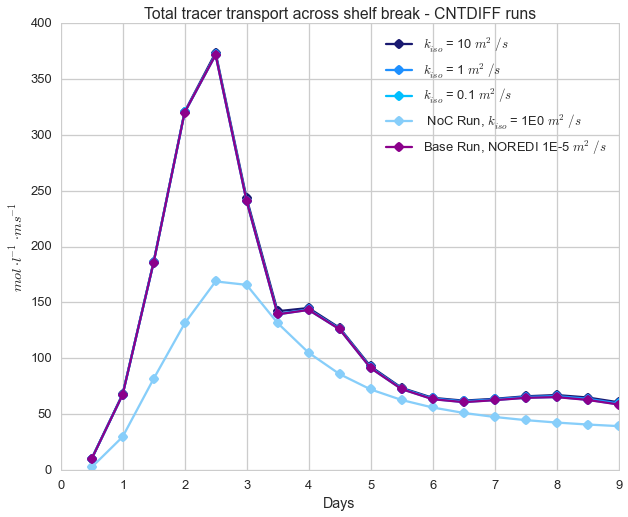

In [27]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransRun02[:],'o-',color=colors[0],label = '$k_{iso}$ = 10 $m^2/s$')
ax.plot(times,ToTalTracTransRun03[:],'o-',color=colors[1],label = '$k_{iso}$ = 1 $m^2/s$')
ax.plot(times,ToTalTracTransRun04[:],'o-',color=colors[2],label = '$k_{iso}$ = 0.1 $m^2/s$')
ax.plot(times,ToTalTracTransBaseNoC[:],'o-',color=colors[3],label = ' NoC Run, $k_{iso}$ = 1E0 $m^2/s$ ')    
ax.plot(times,ToTalTracTransBase[:],'o-',color=colors[4],label = 'Base Run, NOREDI 1E-5 $m^2/s$ ')

handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break - CNTDIFF runs')
    

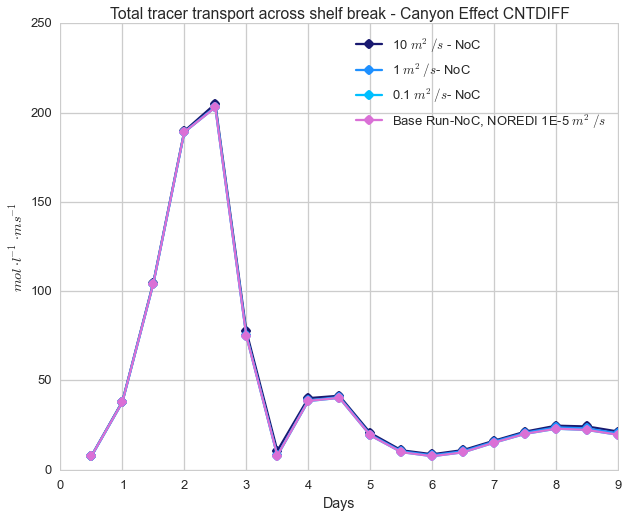

In [28]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransRun02[:]-ToTalTracTransBaseNoC[:],'o-',color=colors[0],label = '10 $m^2/s$ - NoC')
ax.plot(times,ToTalTracTransRun03[:]-ToTalTracTransBaseNoC[:],'o-',color=colors[1],label = '1 $m^2/s$- NoC')
ax.plot(times,ToTalTracTransRun04[:]-ToTalTracTransBaseNoC[:],'o-',color=colors[2],label = '0.1 $m^2/s$- NoC')
ax.plot(times,ToTalTracTransBase[:]-ToTalTracTransBaseNoCNoR[:],'o-',color=colors[5],label = 'Base Run-NoC, NOREDI 1E-5 $m^2/s$ ')
    
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break - Canyon Effect CNTDIFF')
    

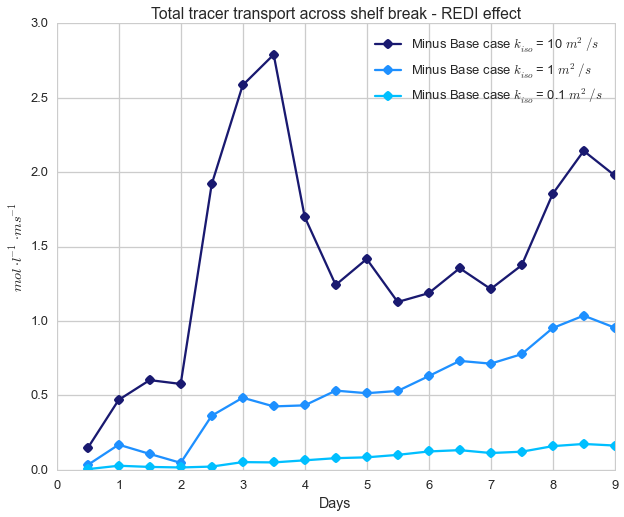

In [26]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()

ax.plot(times,ToTalTracTransRun02[:]-ToTalTracTransBase[:],'o-',color=colors[0],label = 'Minus Base case $k_{iso}$ = 10 $m^2/s$')
ax.plot(times,ToTalTracTransRun03[:]-ToTalTracTransBase[:],'o-',color=colors[1],label = 'Minus Base case $k_{iso}$ = 1 $m^2/s$')
ax.plot(times,ToTalTracTransRun04[:]-ToTalTracTransBase[:],'o-',color=colors[2],label = 'Minus Base case $k_{iso}$ = 0.1 $m^2/s$')
    
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break - REDI effect')
   